In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [2]:
train05 = pd.read_csv('data/2005_data.csv')
train10 = pd.read_csv('data/2010_data.csv')
train15 = pd.read_csv('data/2015_data.csv')
test = pd.read_csv('data/Other_test.csv')
project_data = pd.read_csv('data/Project_Data.csv')

# Resolving accidental impution error
project_data.pct_female = project_data.pct_female.apply(lambda x: 50 if x == .5 else x)
project_data['log_GDP'] = project_data.GDP.apply(lambda x: np.log(x))
project_data['log_drug_deaths'] = project_data['Drug_deaths_per_100,000'].apply(lambda x: np.log(x))
project_data.Homicides = project_data.Homicides.apply(lambda x: project_data.Homicides.mean() if np.isnan(x) else x)
project_data['homicide_rate'] = project_data['Homicides']/project_data['Population']*100
project_data['depression_rate'] = project_data['Depression']/project_data['Population']*100
project_data.elec_acc_pct_pop = project_data.elec_acc_pct_pop.apply(lambda x: 50 if np.isnan(x) else x)
project_data.Urban_population = project_data.apply(lambda x: x.Population*0.5 if np.isnan(x.Urban_population) else x.Urban_population, axis = 1)
project_data.Rural_population = project_data.apply(lambda x: x.Population*0.5 if np.isnan(x.Rural_population) else x.Rural_population, axis = 1)
project_data['conflict_deaths_cat'] = project_data.conflict_deaths.apply(lambda x: 0 if x == 0 else 1)
project_data['inv_hom_rate'] = 1/project_data['homicide_rate']
project_data['log_sui']= np.log(project_data.suicide_death_rate+1e-10)
project_data.rename(columns = {'Drug_deaths_per_100,000': 'drug_deaths_per_100000'}, inplace = True)

# Making the train data once again based on project data, because then when we transform data we don't
# have to do it four times but can only transform the project_data file and the train data will change
# accordingly. 
train05 = project_data.loc[project_data.Year == 2005]
train10 = project_data.loc[project_data.Year == 2010]
train15 = project_data.loc[project_data.Year == 2015]
test = project_data.loc[project_data.Year == 2019]

In [3]:
train05.columns

Index(['Country', 'Alcohol_Consumption', 'GDP', 'Christian', 'Muslim',
       'Irreligion', 'Hindu', 'Buddhist', 'Folk_religion', 'Other_religion',
       'Jewish', 'Democracy', 'Education', 'Wine', 'Year', 'Depression',
       'Homicides', 'Drug_deaths_per_100,000', 'Median_age', 'Population',
       'conflict_deaths', 'deaths_to_pop_rate', 'elec_acc_pct_pop',
       'Urban_population', 'Rural_population', 'pct_female', 'urban_pop_share',
       'suicide_death_rate', 'log_GDP', 'log_drug_deaths'],
      dtype='object')

### Population?

Ultimately I think population is just good to scale the other factors, rather than being a predictor itself. The model shows a severe lack in any possible amount of correlation in the factors, even when taking all the outliers out

<AxesSubplot:xlabel='Population', ylabel='Alcohol_Consumption'>

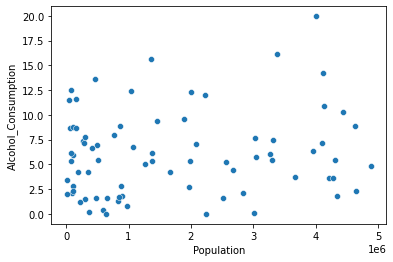

In [4]:
sns.scatterplot(x = train05.Population[train05.Population < 5000000], y = train05.Alcohol_Consumption[train05.Population < 5000000])

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.021
Model:                             OLS   Adj. R-squared:                  0.008
Method:                  Least Squares   F-statistic:                     1.625
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):              0.206
Time:                         13:45:03   Log-Likelihood:                -219.60
No. Observations:                   77   AIC:                             443.2
Df Residuals:                       75   BIC:                             447.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3747      0.722      7.449      0.000       3.937       6.812
Population  3.996e-07   3.13e-07      1.275      0.206   -2.25e-07    1.02e-06
==============================================================================
Omnibus:                        7.634   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.508
Skew:                           0.762   Prob(JB):                       0.0234
Kurtosis:                       3.142   Cond. No.                     3.43e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

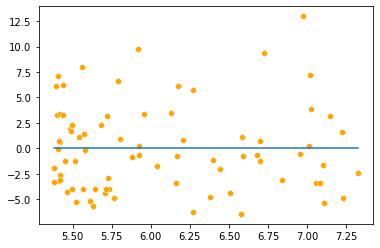

In [5]:
something = train05.loc[train05.Population < 5000000]
model = sm.ols('Alcohol_Consumption ~ Population', something).fit()
sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])
model.summary()

### Elec_acc_pct_pop doesn't have a very good relationship. 
Knowing electricity access doesn't tell you anything about the alcohol consumption, regardless of what transformation you use or how much data you take out

<AxesSubplot:xlabel='elec_acc_pct_pop', ylabel='Alcohol_Consumption'>

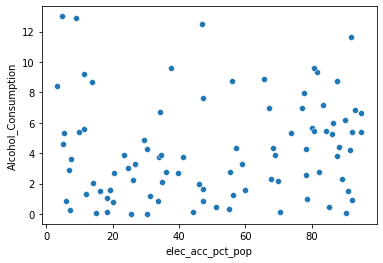

In [6]:
sns.scatterplot(x = train05.elec_acc_pct_pop[train05.elec_acc_pct_pop < 95], y = train05.Alcohol_Consumption[train05.elec_acc_pct_pop < 95])

<AxesSubplot:>

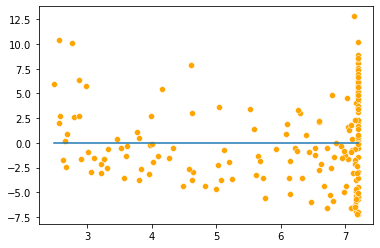

In [7]:
model = sm.ols('Alcohol_Consumption ~ elec_acc_pct_pop', train05).fit()
sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])

### Death rate is also very miniscule, 
basically no relationship between death rate and alcohol consumption. Ultimately I think we just have too many 0 values for it to really matter. As such, I will try turning death rate into a categorical variable, with a 0 for if there are 0 deaths from conflict, and a 1 if there is any. Ultimately, however, I think confl

In [8]:
(train05.deaths_to_pop_rate*train05.Population == 0).sum()

96

In [10]:
model = sm.ols('Alcohol_Consumption ~ conflict_deaths_cat', train05).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.049
Model:                             OLS   Adj. R-squared:                  0.043
Method:                  Least Squares   F-statistic:                     9.488
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):            0.00238
Time:                         13:45:04   Log-Likelihood:                -547.69
No. Observations:                  188   AIC:                             1099.
Df Residuals:                      186   BIC:                             1106.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.9530      0.457     15.206      0.000       6.051       7.855
conflict_deaths_cat    -2.0133      0.654     -3.080      0.002      -3.303      -0.724
==============================================================================
Omnibus:                       14.207   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.019
Skew:                           0.657   Prob(JB):                     0.000548
Kurtosis:                       2.564   Cond. No.                         2.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Median age doesn't have a bad relationship with alcohol consumption. It's likely the best we're going to get with real world data
You can see a clear relationship as well, between median_age, education, and GDP, so it is probably a good idea to include an interaction term with all three of these variables in order to create a good model

In [11]:
project_data.columns

Index(['Country', 'Alcohol_Consumption', 'GDP', 'Christian', 'Muslim',
       'Irreligion', 'Hindu', 'Buddhist', 'Folk_religion', 'Other_religion',
       'Jewish', 'Democracy', 'Education', 'Wine', 'Year', 'Depression',
       'Homicides', 'Drug_deaths_per_100,000', 'Median_age', 'Population',
       'conflict_deaths', 'deaths_to_pop_rate', 'elec_acc_pct_pop',
       'Urban_population', 'Rural_population', 'pct_female', 'urban_pop_share',
       'suicide_death_rate', 'log_GDP', 'log_drug_deaths'],
      dtype='object')

<AxesSubplot:xlabel='Median_age', ylabel='Alcohol_Consumption'>

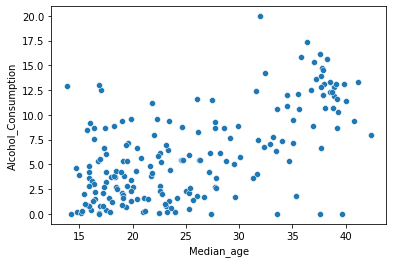

In [12]:
sns.scatterplot(x = train05.Median_age, y = train05.Alcohol_Consumption)

<AxesSubplot:>

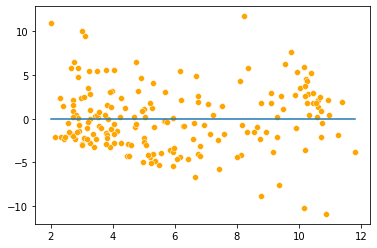

In [13]:
model = sm.ols('Alcohol_Consumption ~ Median_age', data = train05).fit()
sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])

<AxesSubplot:xlabel='Median_age', ylabel='Alcohol_Consumption'>

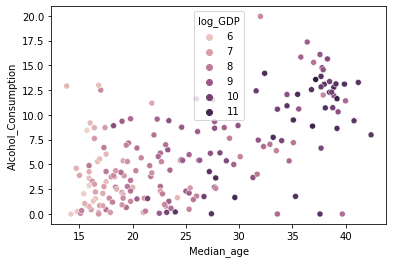

In [14]:
sns.scatterplot(x = train05.Median_age, y = train05.Alcohol_Consumption, hue = train05.log_GDP)

<AxesSubplot:xlabel='Median_age', ylabel='Alcohol_Consumption'>

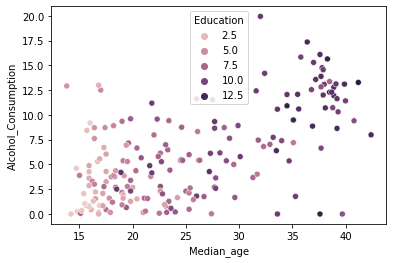

In [15]:
sns.scatterplot(x = train05.Median_age, y = train05.Alcohol_Consumption, hue = train05.Education)

<AxesSubplot:xlabel='log_GDP', ylabel='Alcohol_Consumption'>

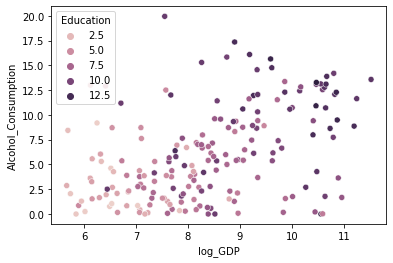

In [16]:
sns.scatterplot(x = train05.log_GDP, y = train05.Alcohol_Consumption, hue = train05.Education)

### drug_deaths_per_100000 also doesn't seem to have any correlation
Scatterplot kinda looks like it has a log relationship, so we will try that in the data, which shows, considering it's real world data, a pretty good fit to the scatterplot

<AxesSubplot:xlabel='drug_deaths_per_100000', ylabel='Alcohol_Consumption'>

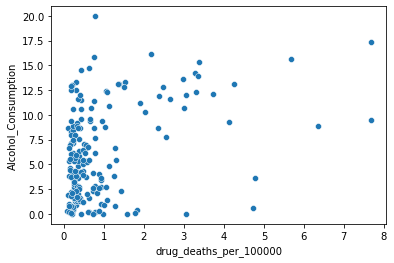

In [18]:
sns.scatterplot(x = train05['drug_deaths_per_100000'], y = train05.Alcohol_Consumption)

<AxesSubplot:>

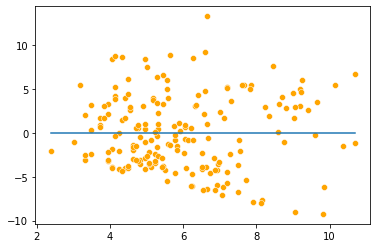

In [19]:
model = sm.ols('Alcohol_Consumption ~ np.log(drug_deaths_per_100000)', train05).fit()
sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])


<AxesSubplot:xlabel='drug_deaths_per_100000', ylabel='Alcohol_Consumption'>

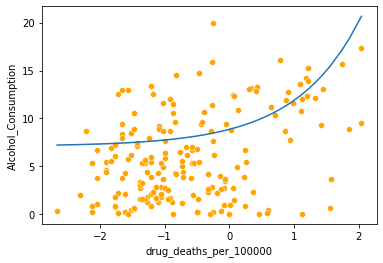

In [20]:
sns.scatterplot(x = np.log(train05['drug_deaths_per_100000']), y = train05.Alcohol_Consumption, color = 'orange')
sns.lineplot(x = np.log(train05['drug_deaths_per_100000']), y = model.params['np.log(drug_deaths_per_100000)']*train05['drug_deaths_per_100000'] + model.params['Intercept'])

In [21]:
#check correlation before: 0.38

#and after log transformation

corr_after = train05['Alcohol_Consumption'].corr(np.log(train05['drug_deaths_per_100000']))
corr_after

0.38284582140592743

### pct_female 
pct_female appears like it could possibly have a positive correlation, however, it isn't completely clear how we could transform the data so it would better fit. The model doesn't appear to be too bad. It is evident, however, that there isn't really any other transformation we could do to fit the data better. If we are to use pct_female as a predictor, however, we would need to get rid of the outlying observations as all other countries are so close to 50% that any observation less than 45 is an extreme outlier that severely affects our fit

In [22]:
possible = train05.loc[train05.pct_female > 45]
# Looking at the weird observations and seeing what country they are
train05.loc[train05.pct_female < 45]

,Country,Alcohol_Consumption,GDP,Christian,Muslim,Irreligion,Hindu,Buddhist,Folk_religion,Other_religion,...,deaths_to_pop_rate,elec_acc_pct_pop,Urban_population,Rural_population,pct_female,urban_pop_share,suicide_death_rate,log_GDP,log_drug_deaths,conflict_deaths_cat
12,Bahrain,1.76,22343.54,14.5,70.3,1.9,9.8,2.5,0.0,0.2,...,0.000000,100.0,786210.0,102947.0,39.927368,88.42,8.5,10.014293,-1.272966,0
89,Kuwait,0.02,39849.60,14.3,74.1,0.0,8.5,2.8,0.0,0.3,...,0.000005,100.0,2270196.0,0.0,40.953335,100.00,3.3,10.592868,-0.867501,1
126,Oman,1.56,19448.46,6.5,85.9,0.2,5.5,0.8,0.0,1.0,...,0.000000,100.0,1818148.0,693106.0,43.440567,72.40,3.8,9.875523,-0.941609,0
135,Qatar,1.67,57624.13,14.2,65.5,0.9,15.1,3.1,0.0,0.7,...,0.000002,100.0,842875.0,22535.0,32.442890,97.40,5.5,10.961697,-1.139434,1
144,Saudi Arabia,0.17,18683.38,4.4,93.0,0.7,1.1,0.3,0.3,0.3,...,0.000001,100.0,19286100.0,4530075.0,44.319687,80.98,3.2,9.835390,-0.494296,1
176,United Arab Emirates,3.64,53844.72,14.0,70.0,1.1,10.0,2.0,0.0,0.8,...,0.000000,100.0,3774363.0,813859.0,29.613279,82.26,6.1,10.893860,1.562346,0


<AxesSubplot:>

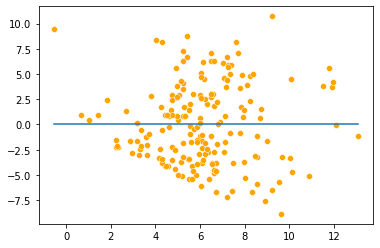

In [23]:
model = sm.ols('Alcohol_Consumption ~ pct_female', data = possible).fit()
sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.228
Model:                             OLS   Adj. R-squared:                  0.224
Method:                  Least Squares   F-statistic:                     53.30
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           8.87e-12
Time:                         13:45:05   Log-Likelihood:                -510.92
No. Observations:                  182   AIC:                             1026.
Df Residuals:                      180   BIC:                             1032.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -89.1143     13.047     -6.830      0.000    -114.859     -63.370
pct_female     1.8873      0.258      7.301      0.000       1.377       2.397
==============================================================================
Omnibus:                        8.181   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                5.936
Skew:                           0.319   Prob(JB):                       0.0514
Kurtosis:                       2.388   Cond. No.                     2.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='pct_female', ylabel='Alcohol_Consumption'>

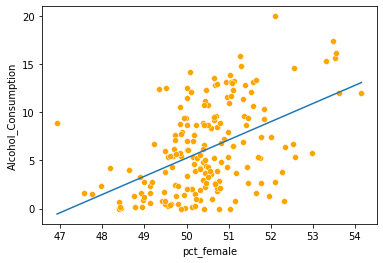

In [25]:
sns.scatterplot(x = train05.pct_female[train05.pct_female > 45], y = train05.Alcohol_Consumption[train05.pct_female > 45], color = 'orange')
sns.lineplot(x = possible.pct_female, y = possible.pct_female*model.params['pct_female'] + model.params['Intercept'])

In [26]:
train05.corrwith(train05.Alcohol_Consumption)

Alcohol_Consumption       1.000000
GDP                       0.369669
Christian                 0.421446
Muslim                   -0.490820
Irreligion                0.398835
Hindu                    -0.137425
Buddhist                 -0.115469
Folk_religion            -0.116362
Other_religion           -0.058865
Jewish                   -0.001268
Democracy                 0.464541
Education                 0.535028
Wine                      0.067537
Year                           NaN
Depression               -0.017159
Homicides                 0.000983
drug_deaths_per_100000    0.381714
Median_age                0.607239
Population               -0.021974
conflict_deaths          -0.040442
deaths_to_pop_rate       -0.019191
elec_acc_pct_pop          0.343108
Urban_population         -0.005129
Rural_population         -0.037088
pct_female                0.337883
urban_pop_share           0.298593
suicide_death_rate        0.299399
log_GDP                   0.437734
log_drug_deaths     

## Modifying depression and homicide predictors to their respective rates for train05:

In [142]:
train05['depression_rate'].head()

0    3.475991
1    2.536836
2    3.986741
3    4.129250
4    3.838273
Name: depression_rate, dtype: float64

In [143]:
train05['homicide_rate'].head()

0    0.010106
1    0.005210
2    0.001481
3    6.430180
4    0.012061
Name: homicide_rate, dtype: float64

In [29]:
train05.corrwith(train05.Alcohol_Consumption)

Alcohol_Consumption       1.000000
GDP                       0.369669
Christian                 0.421446
Muslim                   -0.490820
Irreligion                0.398835
Hindu                    -0.137425
Buddhist                 -0.115469
Folk_religion            -0.116362
Other_religion           -0.058865
Jewish                   -0.001268
Democracy                 0.464541
Education                 0.535028
Wine                      0.067537
Year                           NaN
Depression               -0.017159
Homicides                 0.000983
drug_deaths_per_100000    0.381714
Median_age                0.607239
Population               -0.021974
conflict_deaths          -0.040442
deaths_to_pop_rate       -0.019191
elec_acc_pct_pop          0.343108
Urban_population         -0.005129
Rural_population         -0.037088
pct_female                0.337883
urban_pop_share           0.298593
suicide_death_rate        0.299399
log_GDP                   0.437734
log_drug_deaths     

## Homicide_rate
Initially it can be derived from the above data that homicide rate as a predictor has a negligible negative correlation with alcohol consumption; it is approximately 0.01. Let's visualize it against alcohol consumption:

<AxesSubplot:xlabel='homicide_rate', ylabel='Alcohol_Consumption'>

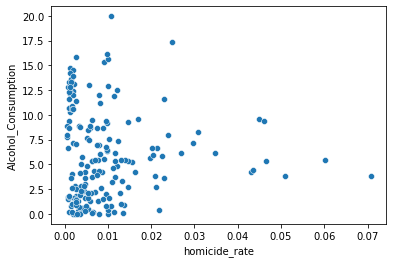

In [30]:
sns.scatterplot(x = train05['homicide_rate'], y = train05.Alcohol_Consumption)

### I am going to check for possible transformations to see if I can get a better correlation:

In [31]:
#create copy of train dataset 

train5 = train05.dropna()

corr_log = train5['Alcohol_Consumption'].corr(np.log(train5['homicide_rate']+1e-10))

# Print the correlation

print(f"Correlation with log: {corr_log:.2f}")

# Calculate the correlations
corr_sq = train5['Alcohol_Consumption'].corr(train5['homicide_rate']**2)
corr_cube = train5['Alcohol_Consumption'].corr(train5['homicide_rate']**3)
corr_sq_root = train5['Alcohol_Consumption'].corr(train5['homicide_rate']**(1/2))
corr_inv = train5['Alcohol_Consumption'].corr(1/(train5['homicide_rate']))


# Print the correlations
print(f"Correlation with square: {corr_sq:.2f}")
print(f"Correlation with cube: {corr_cube:.2f}")
print(f"Correlation with square root: {corr_sq_root:.2f}")
print(f"Correlation with inverse: {corr_inv:.2f}")


Correlation with log: -0.12
Correlation with square: -0.01
Correlation with cube: -0.02
Correlation with square root: -0.06
Correlation with inverse: 0.19


### It looks like tranforming the homicide rate by taking the inverse of it bumps up the correlation to 0.19, so let's try to visualize the response with the transformed variable:

<AxesSubplot:xlabel='homicide_rate', ylabel='Alcohol_Consumption'>

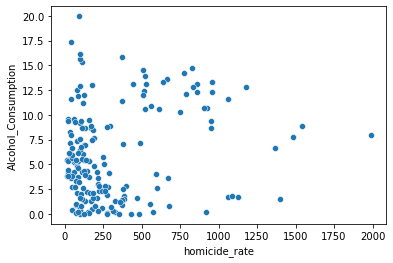

In [32]:
sns.scatterplot(x = 1/train05['homicide_rate'], y =train05['Alcohol_Consumption'])

In [144]:
model_hom = sm.ols('Alcohol_Consumption ~ inv_hom_rate', train05).fit()
model_hom.summary()
# sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
# sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.033
Model:                             OLS   Adj. R-squared:                  0.028
Method:                  Least Squares   F-statistic:                     6.350
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):             0.0126
Time:                         14:27:48   Log-Likelihood:                -549.21
No. Observations:                  188   AIC:                             1102.
Df Residuals:                      186   BIC:                             1109.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.2292      0.441     11.860      0.000       4.359       6.099
inv_hom_rate     0.0024      0.001      2.520      0.013       0.001       0.004
==============================================================================
Omnibus:                       10.096   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.525
Skew:                           0.552   Prob(JB):                      0.00518
Kurtosis:                       2.644   Cond. No.                         620.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Even though transforming homicide_rate did bump up the correlation significantly between the predictor and the response, they still don't have a strong relationship and the model fit is not good/useful, as can be seen by the R^2 value of 0.038. We will therefore continue without this predictor.

## Depression_rate
The depression_rate predictor has a correlation of almost 0.38 with alcohol consumption, therefore it is definitely worth it exploring the relationship:

<AxesSubplot:xlabel='depression_rate', ylabel='Alcohol_Consumption'>

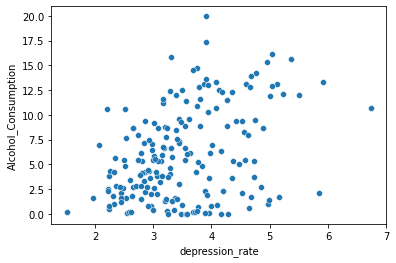

In [34]:
sns.scatterplot(x = train05['depression_rate'], y = train05.Alcohol_Consumption)

Performing transformations here could prove helpful
, so let's check the resulting correlations from different variable transformations:

In [35]:
#using previous train05 copy "train5" (no Na values)

corr_log = train5['Alcohol_Consumption'].corr(np.log(train5['depression_rate']+1e-10))

# Print the correlation

print(f"Correlation with log: {corr_log:.2f}")

# Calculate the correlations
corr_sq = train5['Alcohol_Consumption'].corr(train5['depression_rate']**2)
corr_cube = train5['Alcohol_Consumption'].corr(train5['depression_rate']**3)
corr_sq_root = train5['Alcohol_Consumption'].corr(train5['depression_rate']**(1/2))
corr_inv = train5['Alcohol_Consumption'].corr(1/(train5['depression_rate']))


# Print the correlations
print(f"Correlation with square: {corr_sq:.2f}")
print(f"Correlation with cube: {corr_cube:.2f}")
print(f"Correlation with square root: {corr_sq_root:.2f}")
print(f"Correlation with inverse: {corr_inv:.2f}")


Correlation with log: 0.37
Correlation with square: 0.36
Correlation with cube: 0.34
Correlation with square root: 0.37
Correlation with inverse: -0.36


It looks like no transformation is appropriate. Let's try fitting the model:

In [36]:
model_dep = sm.ols('Alcohol_Consumption ~ depression_rate', train05).fit()
model_dep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.144
Model:                             OLS   Adj. R-squared:                  0.140
Method:                  Least Squares   F-statistic:                     31.35
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           7.65e-08
Time:                         13:45:06   Log-Likelihood:                -537.72
No. Observations:                  188   AIC:                             1079.
Df Residuals:                      186   BIC:                             1086.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.0021      1.283     -0.781      0.436      -3.533       1.529
depression_rate     1.9856      0.355      5.599      0.000       1.286       2.685
==============================================================================
Omnibus:                        3.223   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.200   Jarque-Bera (JB):                3.074
Skew:                           0.252   Prob(JB):                        0.215
Kurtosis:                       2.628   Cond. No.                         16.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

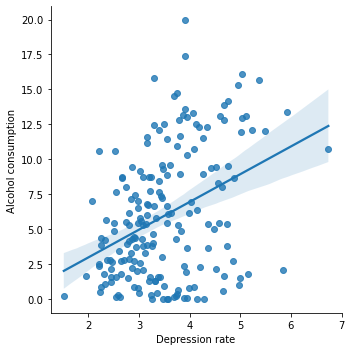

In [37]:
# Create scatterplot with regression line and confidence intervals
sns.lmplot(x='depression_rate', y='Alcohol_Consumption', data=train05, ci=95)

# Set axis labels
plt.xlabel('Depression rate')
plt.ylabel('Alcohol consumption')
plt.show()


In [38]:
#checking correlations with other preds
train05.corrwith(train05.depression_rate)

Alcohol_Consumption       0.379779
GDP                       0.306222
Christian                 0.101345
Muslim                   -0.052130
Irreligion                0.181094
Hindu                     0.103982
Buddhist                 -0.187626
Folk_religion            -0.170250
Other_religion           -0.141398
Jewish                    0.113597
Democracy                 0.262604
Education                 0.247514
Wine                      0.072896
Year                           NaN
Depression                0.019102
Homicides                 0.005636
drug_deaths_per_100000    0.389573
Median_age                0.410815
Population                0.006516
conflict_deaths          -0.010431
deaths_to_pop_rate       -0.018397
elec_acc_pct_pop          0.214430
Urban_population          0.014067
Rural_population         -0.000270
pct_female               -0.020278
urban_pop_share           0.326283
suicide_death_rate        0.159771
log_GDP                   0.331656
log_drug_deaths     

### Multicollinearity concerns

As we can see above, depression_rate has a moderately high correlation with the drug deaths and median_age predictors. In the future, in the process of deriving the best, most accurate MLR model we can, we should keep this in mind and should any issues arise, resolve them by removing either of the predictors, using an interaction term to reduce multicollinearity or utilize regularization (Ridge/Lasso regression).

(other predictors very highly correlated (scale of 0.6-0.8 correlation), such as GDP- Median_Age -Education, indicating collinearity issues which may need to be taken care of. Below I have made a first attempt at a MLR model with an interaction term of those highly correlated variables instead.)

## Attempting predictor combinations for MLR model

In [39]:
#fit MLR model 
model1= sm.ols('Alcohol_Consumption ~ depression_rate*drug_deaths_per_100000 + depression_rate*Median_age + Median_age*GDP*Education + Christian*Muslim*Irreligion', train05).fit()
model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.591
Model:                             OLS   Adj. R-squared:                  0.548
Method:                  Least Squares   F-statistic:                     13.57
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           2.35e-24
Time:                         13:45:06   Log-Likelihood:                -468.30
No. Observations:                  188   AIC:                             974.6
Df Residuals:                      169   BIC:                             1036.
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  4.6954      4.534      1.036      0.302      -4.255      13.646
depression_rate                            1.1920      1.058      1.127      0.261      -0.897       3.281
drug_deaths_per_100000                     0.6769      1.242      0.545      0.586      -1.774       3.128
depression_rate:drug_deaths_per_100000    -0.0555      0.295     -0.188      0.851      -0.637       0.526
Median_age                                -0.2348      0.214     -1.096      0.274      -0.658       0.188
depression_rate:Median_age                -0.0249      0.043     -0.576      0.565      -0.110       0.061
GDP                                       -0.0005      0.000     -1.065      0.289      -0.001       0.000
Median_age:GDP                          2.542e-05   1.56e-05      1.627      0.106   -5.42e-06    5.63e-05
Education                                 -0.6442      0.360     -1.788      0.076      -1.355       0.067
Median_age:Education                       0.0469      0.017      2.795      0.006       0.014       0.080
GDP:Education                            1.92e-05   4.92e-05      0.390      0.697    -7.8e-05       0.000
Median_age:GDP:Education               -1.604e-06   1.48e-06     -1.083      0.280   -4.53e-06    1.32e-06
Christian                                  0.0055      0.009      0.584      0.560      -0.013       0.024
Muslim                                    -0.0342      0.011     -3.221      0.002      -0.055      -0.013
Christian:Muslim                           0.0013      0.001      2.578      0.011       0.000       0.002
Irreligion                                -0.0329      0.034     -0.979      0.329      -0.099       0.033
Christian:Irreligion                       0.0018      0.001      2.273      0.024       0.000       0.003
Muslim:Irreligion                         -0.0043      0.007     -0.609      0.543      -0.018       0.010
Christian:Muslim:Irreligion            -3.692e-05      0.000     -0.219      0.827      -0.000       0.000
==============================================================================
Omnibus:                       14.025   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               40.930
Skew:                          -0.014   Prob(JB):                     1.29e-09
Kurtosis:                       5.286   Cond. No.                     1.67e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### GDP Per Capita

GDP per capita has a correlation of 0.37 with alcohol consumption, so it is definitely a worthwhile relationship to explore.

<AxesSubplot:xlabel='GDP', ylabel='Alcohol_Consumption'>

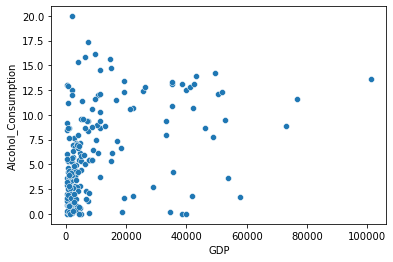

In [40]:
sns.scatterplot(data=train05, x='GDP', y='Alcohol_Consumption')

Given the uneven scatter of the data towards the $0-10,000 per capita side, a log transformation might be helpful.

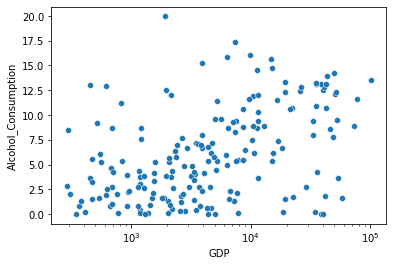

In [41]:
sns.scatterplot(data=train05, x='GDP', y='Alcohol_Consumption')
plt.xscale('log')

In [42]:
model = sm.ols('Alcohol_Consumption ~ np.log(GDP)', train05).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.192
Model:                             OLS   Adj. R-squared:                  0.187
Method:                  Least Squares   F-statistic:                     44.09
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           3.35e-10
Time:                         13:45:06   Log-Likelihood:                -532.37
No. Observations:                  188   AIC:                             1069.
Df Residuals:                      186   BIC:                             1075.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.7336      1.788     -3.207      0.002      -9.261      -2.207
np.log(GDP)     1.3949      0.210      6.640      0.000       0.980       1.809
==============================================================================
Omnibus:                        9.832   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.012
Skew:                           0.491   Prob(JB):                      0.00670
Kurtosis:                       3.562   Cond. No.                         51.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
model = sm.ols('Alcohol_Consumption ~ GDP', train05).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.137
Model:                             OLS   Adj. R-squared:                  0.132
Method:                  Least Squares   F-statistic:                     29.44
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           1.78e-07
Time:                         13:45:06   Log-Likelihood:                -538.55
No. Observations:                  188   AIC:                             1081.
Df Residuals:                      186   BIC:                             1088.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8135      0.377     12.768      0.000       4.070       5.557
GDP            0.0001   1.87e-05      5.426      0.000    6.46e-05       0.000
==============================================================================
Omnibus:                       10.842   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.076
Skew:                           0.577   Prob(JB):                      0.00394
Kurtosis:                       3.288   Cond. No.                     2.44e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### The R^2 increases by about 0.04, and visually there is a stronger linear relationship. Thus, we should use a log transformation of GDP in the final model.

In [44]:
train05.corrwith(train05.GDP)

Alcohol_Consumption       0.369669
GDP                       1.000000
Christian                 0.105535
Muslim                   -0.169810
Irreligion                0.354946
Hindu                    -0.032622
Buddhist                 -0.054418
Folk_religion            -0.156830
Other_religion            0.098936
Jewish                    0.076055
Democracy                 0.441574
Education                 0.560661
Wine                      0.060613
Year                           NaN
Depression               -0.018207
Homicides                -0.032164
drug_deaths_per_100000    0.520667
Median_age                0.626984
Population               -0.023319
conflict_deaths          -0.041921
deaths_to_pop_rate       -0.072208
elec_acc_pct_pop          0.452635
Urban_population         -0.005438
Rural_population         -0.039506
pct_female               -0.235802
urban_pop_share           0.600711
suicide_death_rate       -0.100536
log_GDP                   0.819579
log_drug_deaths     

#### Interaction terms with democracy, education, and median age would be logical.

### Wine

Given the extremely high correlations between wine production and both rural and urban population (~0.9), there is a good chance this is a confounded variable that actually reflects a nation's population. Let's visualize the scatter plots:

<AxesSubplot:xlabel='Wine', ylabel='Urban_population'>

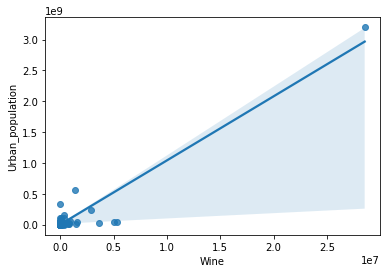

In [45]:
sns.regplot(data=train05, x='Wine', y='Urban_population')


<AxesSubplot:xlabel='Wine', ylabel='Rural_population'>

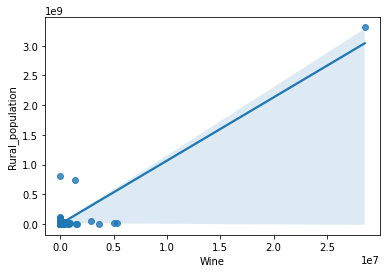

In [46]:
sns.regplot(data=train05, x='Wine', y='Rural_population')


Both of these variables suffer from having a vast majority of points that are extremely small in value-- for example, most countries have no wine production given climate and cultural limitations. As for population, there are a handful of countries with extremely high urban/rural populations, whereas most are concentrated in the 0-20 million range. That said, when removing outliers, we see a strong linear relationship with both rural and urban population, indicating a confounding effect of overall population on wine production (higher population countries produce more wine). 

In [47]:
train05['Wine'].corr(train05['Population'])

0.9327003097277932

#### Thus, we will not regress with wine production. 

### Religion


Immediately, there will be an issue of multicollinearity if we include all of the religion variables. We need to choose a couple that will be the most useful. Subjectively, it seems that percentage of Muslim population will be a useful predictor, given that Islam prohibits drinking alcohol.

<AxesSubplot:xlabel='Muslim', ylabel='Alcohol_Consumption'>

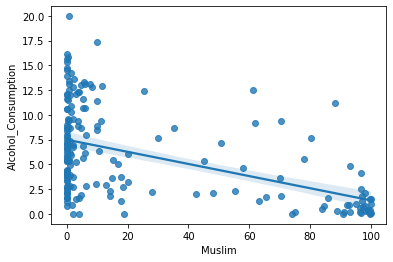

In [48]:
sns.regplot(data=train05, x='Muslim', y='Alcohol_Consumption')

<AxesSubplot:xlabel='Christian', ylabel='Alcohol_Consumption'>

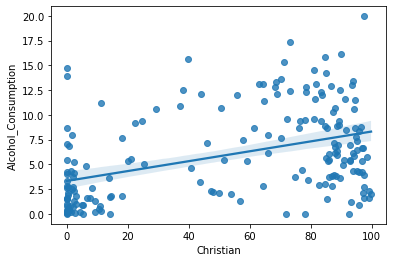

In [49]:
sns.regplot(data=train05, x='Christian', y='Alcohol_Consumption')

Christianity is a slightly less useful predictor, and has less intuitive of a relationship. That said, given that there is a decently high R^2, we should include it in our variable selection techniques. 

#### Include Christianity and Islam. 

### Education


Education has one of the strongest correlations with alcohol consumption. Will a transformation help?

<AxesSubplot:xlabel='Education', ylabel='Alcohol_Consumption'>

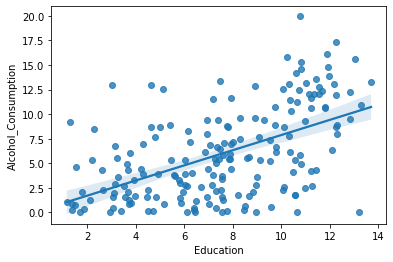

In [50]:
sns.regplot(data=train05, x='Education', y='Alcohol_Consumption')

There is a strong linear relationship, and a transformation does not make sense given even scatter and visually a linear trend. 

In [51]:
train05['Education'].corr(train05['Alcohol_Consumption'])

0.5350277630321116

#### Include education, untranformed. 

### Democracy

<AxesSubplot:xlabel='Democracy', ylabel='Alcohol_Consumption'>

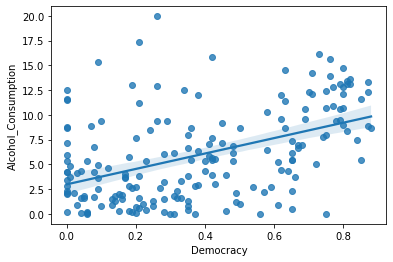

In [52]:
sns.regplot(data=train05, x='Democracy', y='Alcohol_Consumption')

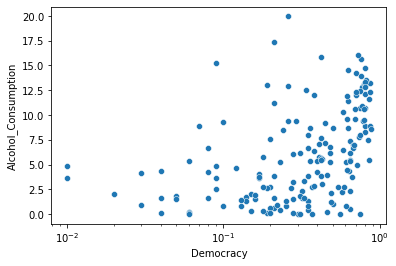

In [53]:
sns.scatterplot(data=train05, x='Democracy', y='Alcohol_Consumption')
plt.xscale('log')

In [54]:
model = sm.ols('Alcohol_Consumption ~ Democracy', train05).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.216
Model:                             OLS   Adj. R-squared:                  0.212
Method:                  Least Squares   F-statistic:                     51.18
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           1.88e-11
Time:                         13:45:08   Log-Likelihood:                -529.51
No. Observations:                  188   AIC:                             1063.
Df Residuals:                      186   BIC:                             1069.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9852      0.512      5.834      0.000       1.976       3.995
Democracy      7.7814      1.088      7.154      0.000       5.636       9.927
==============================================================================
Omnibus:                       19.578   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.594
Skew:                           0.764   Prob(JB):                     1.24e-05
Kurtosis:                       3.741   Cond. No.                         4.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
model = sm.ols('Alcohol_Consumption ~ np.log(Democracy+0.1)', train05).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.141
Model:                             OLS   Adj. R-squared:                  0.136
Method:                  Least Squares   F-statistic:                     30.49
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           1.12e-07
Time:                         13:45:08   Log-Likelihood:                -538.09
No. Observations:                  188   AIC:                             1080.
Df Residuals:                      186   BIC:                             1087.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.2638      0.519     15.925      0.000       7.240       9.288
np.log(Democracy + 0.1)     2.4592      0.445      5.522      0.000       1.581       3.338
==============================================================================
Omnibus:                       11.409   Durbin-Watson:                   1.629
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.194
Skew:                           0.624   Prob(JB):                      0.00225
Kurtosis:                       3.029   Cond. No.                         3.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### A transformation of democracy does not make sense, as it reduces model R^2. Thus, we should include democracy, without a transformation. As outlined previously, interaction with democracy should be considered. 

# Urban_pop_share

In [56]:
corr = train05['urban_pop_share'].corr(train05['Alcohol_Consumption'])
corr_log = train05['urban_pop_share'].corr(np.log(train05['Alcohol_Consumption']+1e-10))
corr_sq = train05['urban_pop_share'].corr(train05['Alcohol_Consumption']**2)
corr_cube = train05['urban_pop_share'].corr(train05['Alcohol_Consumption']**3)
corr_inv = train05['urban_pop_share'].corr(1/(train05['Alcohol_Consumption']+1e-10))

print(f"Correlation: {corr:.2f}")
print(f"Correlation with square: {corr_sq:.2f}")
print(f"Correlation with cube: {corr_cube:.2f}")
print(f"Correlation with inverse: {corr_inv:.2f}")
print(f"Correlation with log: {corr:.2f}")


Correlation: 0.30
Correlation with square: 0.27
Correlation with cube: 0.23
Correlation with inverse: -0.03
Correlation with log: 0.30


<AxesSubplot:xlabel='urban_pop_share', ylabel='Alcohol_Consumption'>

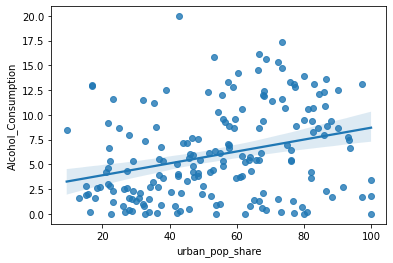

In [57]:
sns.regplot(x = train05['urban_pop_share'], y = train05.Alcohol_Consumption)

In [58]:
model = sm.ols('Alcohol_Consumption ~ urban_pop_share', train05).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.089
Model:                             OLS   Adj. R-squared:                  0.084
Method:                  Least Squares   F-statistic:                     18.21
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           3.15e-05
Time:                         13:45:08   Log-Likelihood:                -543.59
No. Observations:                  188   AIC:                             1091.
Df Residuals:                      186   BIC:                             1098.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7113      0.827      3.277      0.001       1.079       4.344
urban_pop_share     0.0600      0.014      4.267      0.000       0.032       0.088
==============================================================================
Omnibus:                        7.934   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                8.316
Skew:                           0.509   Prob(JB):                       0.0156
Kurtosis:                       2.844   Cond. No.                         152.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

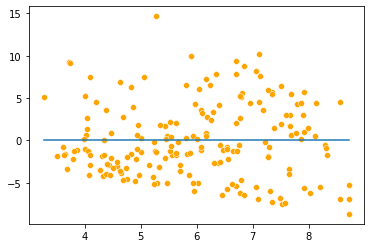

In [59]:
sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])


# Suicide death rate

In [60]:
corr = train05['suicide_death_rate'].corr(train05['Alcohol_Consumption'])
corr_log = train05['suicide_death_rate'].corr(np.log(train05['Alcohol_Consumption']+1e-10))
corr_sq = train05['suicide_death_rate'].corr(train05['Alcohol_Consumption']**2)
corr_cube = train05['suicide_death_rate'].corr(train05['Alcohol_Consumption']**3)
corr_inv = train05['suicide_death_rate'].corr(1/(train05['Alcohol_Consumption']+1e-10))

print(f"Correlation: {corr:.2f}")
print(f"Correlation with square: {corr_sq:.2f}")
print(f"Correlation with cube: {corr_cube:.2f}")
print(f"Correlation with inverse: {corr_inv:.2f}")
print(f"Correlation with log: {corr:.2f}")


Correlation: 0.30
Correlation with square: 0.31
Correlation with cube: 0.32
Correlation with inverse: 0.01
Correlation with log: 0.30


In [61]:
train05['log_sui']= np.log(train05.suicide_death_rate+1e-10)
model = sm.ols('Alcohol_Consumption ~ log_sui', train05).fit()
model.summary()

/var/folders/5n/yrnrzmms4jgbmdshn221wy3m0000gn/T/ipykernel_23774/3988521484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train05['log_sui']= np.log(train05.suicide_death_rate+1e-10)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.091
Model:                             OLS   Adj. R-squared:                  0.086
Method:                  Least Squares   F-statistic:                     18.65
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           2.55e-05
Time:                         13:45:08   Log-Likelihood:                -543.38
No. Observations:                  188   AIC:                             1091.
Df Residuals:                      186   BIC:                             1097.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0247      1.188      0.862      0.390      -1.320       3.369
log_sui        2.1593      0.500      4.319      0.000       1.173       3.146
==============================================================================
Omnibus:                       17.190   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.191
Skew:                           0.462   Prob(JB):                      0.00371
Kurtosis:                       2.241   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='log_sui', ylabel='Alcohol_Consumption'>

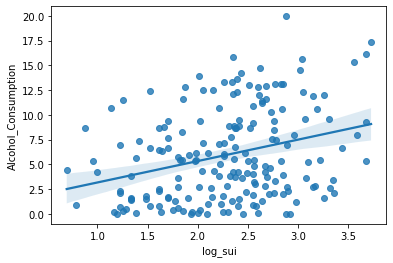

In [62]:
sns.regplot(x = train05['log_sui'], y = train05.Alcohol_Consumption)

<AxesSubplot:>

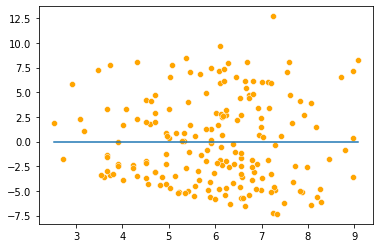

In [63]:
sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])


## CHRISTINA : Stepwise selection

As a computationally more efficient alternative to the Best Subset selection algorithm, we are going to move forward by utilizing the methods of Forward & Backward Stepwise selection using the same starting subset of predictors.

### A) Forward Stepwise selection

In [65]:
X = train05[['Christian', 'Muslim','Democracy', 'Education',
             'drug_deaths_per_100000', 'Median_age', 'elec_acc_pct_pop', 'pct_female', 'urban_pop_share',
       'suicide_death_rate', 'log_GDP', 'log_drug_deaths',
       'conflict_deaths_cat', 'depression_rate',
       'inv_hom_rate', 'log_sui']]
X

,Christian,Muslim,Democracy,Education,drug_deaths_per_100000,Median_age,elec_acc_pct_pop,pct_female,urban_pop_share,suicide_death_rate,log_GDP,log_drug_deaths,conflict_deaths_cat,depression_rate,inv_hom_rate,log_sui
0,0.01,99.7,0.30,1.69,1.59,14.2,25.390894,48.391899,22.70,8.1,5.846236,0.463734,1,3.475991,98.950936,2.091864
1,18.00,80.3,0.42,9.08,0.78,29.1,100.000000,49.722366,46.73,5.5,7.891895,-0.248461,1,2.536836,191.938987,1.704748
2,1.00,98.0,0.25,7.04,1.27,23.1,98.889610,49.423321,63.83,4.6,8.230071,0.239017,1,3.986741,675.342008,1.526056
3,89.50,0.8,0.00,10.09,0.31,36.8,100.000000,50.000000,90.29,7.8,10.591193,-1.171183,0,4.129250,NaN,2.054124
4,90.50,1.0,0.09,3.63,0.36,15.9,29.527786,50.397930,56.00,14.5,8.077161,-1.021651,1,3.838273,82.911176,2.674149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,8.20,0.2,0.19,6.70,0.72,25.4,96.099998,50.459015,27.28,8.4,7.149407,-0.328504,1,2.473103,599.870851,2.128232
184,0.00,0.0,0.42,7.42,1.30,26.3,80.647987,49.612801,49.15,13.0,9.066006,0.262364,1,3.547332,140.149035,2.564949
185,0.20,99.1,0.18,1.86,0.88,15.2,54.904819,49.598286,28.94,6.4,7.838418,-0.127833,1,3.747719,215.796316,1.856298
186,97.60,1.0,0.46,6.05,0.49,15.0,23.321308,50.566765,36.91,17.4,6.822535,-0.713350,0,2.770614,131.718383,2.856470


In [66]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('Alcohol_Consumption~' + '+'.join(predictor_subset),data = train05).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [67]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [68]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [69]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [70]:
models_best = forward_selection()

Processed  16 models on 1 predictors in 0.07875323295593262 seconds.
Processed  15 models on 2 predictors in 0.04640603065490723 seconds.
Processed  14 models on 3 predictors in 0.04988527297973633 seconds.
Processed  13 models on 4 predictors in 0.055084228515625 seconds.
Processed  12 models on 5 predictors in 0.05688285827636719 seconds.
Processed  11 models on 6 predictors in 0.06073117256164551 seconds.
Processed  10 models on 7 predictors in 0.05481219291687012 seconds.
Processed  9 models on 8 predictors in 0.055374860763549805 seconds.
Processed  8 models on 9 predictors in 0.06012415885925293 seconds.
Processed  7 models on 10 predictors in 0.05921006202697754 seconds.
Processed  6 models on 11 predictors in 0.050826072692871094 seconds.
Processed  5 models on 12 predictors in 0.06909418106079102 seconds.
Processed  4 models on 13 predictors in 0.046949148178100586 seconds.
Processed  3 models on 14 predictors in 0.03469419479370117 seconds.
Processed  2 models on 15 predictor

In [71]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

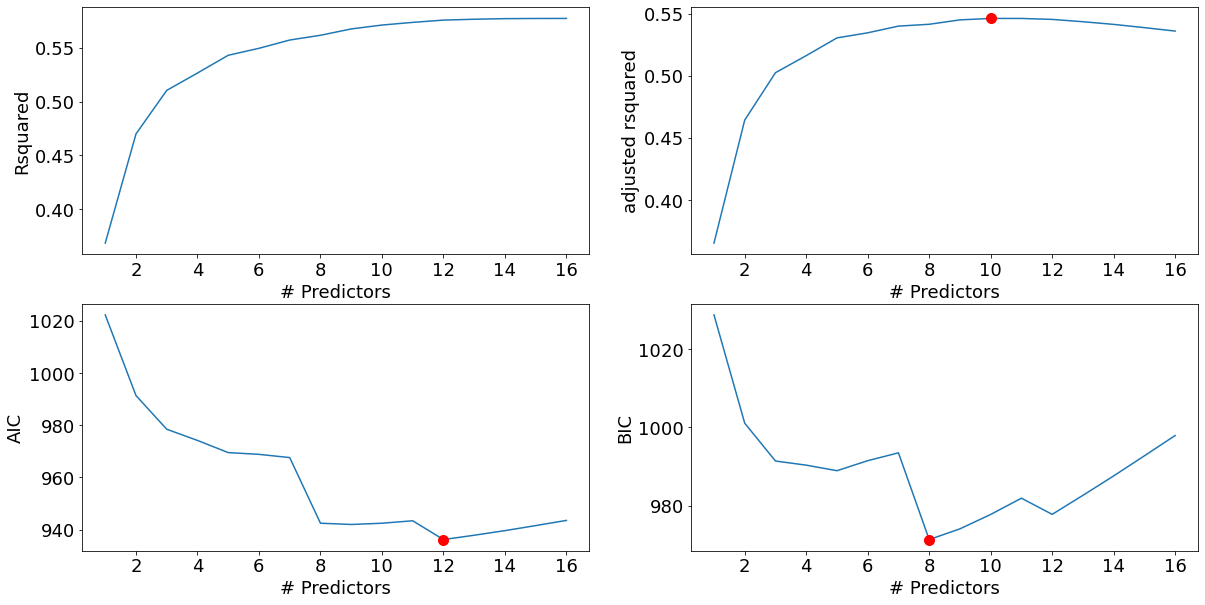

In [71]:
best_sub_plots()

In [72]:
best_fwd_reg_model = models_best['model'][8]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.562
Model:                             OLS   Adj. R-squared:                  0.541
Method:                  Least Squares   F-statistic:                     27.85
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           1.51e-27
Time:                         14:06:29   Log-Likelihood:                -462.24
No. Observations:                  183   AIC:                             942.5
Df Residuals:                      174   BIC:                             971.4
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -17.2472      5.105     -3.378      0.001     -27.323      -7.171
Median_age                 0.2298      0.046      4.963      0.000       0.138       0.321
Christian                  0.0211      0.008      2.596      0.010       0.005       0.037
log_sui                    0.9575      0.409      2.343      0.020       0.151       1.764
pct_female                 0.2400      0.103      2.323      0.021       0.036       0.444
depression_rate            0.6362      0.305      2.086      0.038       0.034       1.238
Muslim                    -0.0163      0.009     -1.730      0.085      -0.035       0.002
drug_deaths_per_100000     0.3993      0.213      1.879      0.062      -0.020       0.819
inv_hom_rate              -0.0005      0.001     -0.551      0.582      -0.002       0.001
==============================================================================
Omnibus:                       14.706   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               40.653
Skew:                           0.173   Prob(JB):                     1.49e-09
Kurtosis:                       5.283   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### B) Backward Stepwise Selection

In [73]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [74]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [75]:
models_best = backward_selection()

Processed  16 models on 15 predictors in 0.18767189979553223 seconds.
Processed  15 models on 14 predictors in 0.15363216400146484 seconds.
Processed  14 models on 13 predictors in 0.14410996437072754 seconds.
Processed  13 models on 12 predictors in 0.1382598876953125 seconds.
Processed  12 models on 11 predictors in 0.11510682106018066 seconds.
Processed  11 models on 10 predictors in 0.09298110008239746 seconds.
Processed  10 models on 9 predictors in 0.07291507720947266 seconds.
Processed  9 models on 8 predictors in 0.06057000160217285 seconds.
Processed  8 models on 7 predictors in 0.053678035736083984 seconds.
Processed  7 models on 6 predictors in 0.09393501281738281 seconds.
Processed  6 models on 5 predictors in 0.027972936630249023 seconds.
Processed  5 models on 4 predictors in 0.021697044372558594 seconds.
Processed  4 models on 3 predictors in 0.01978778839111328 seconds.
Processed  3 models on 2 predictors in 0.011519908905029297 seconds.
Processed  2 models on 1 predict

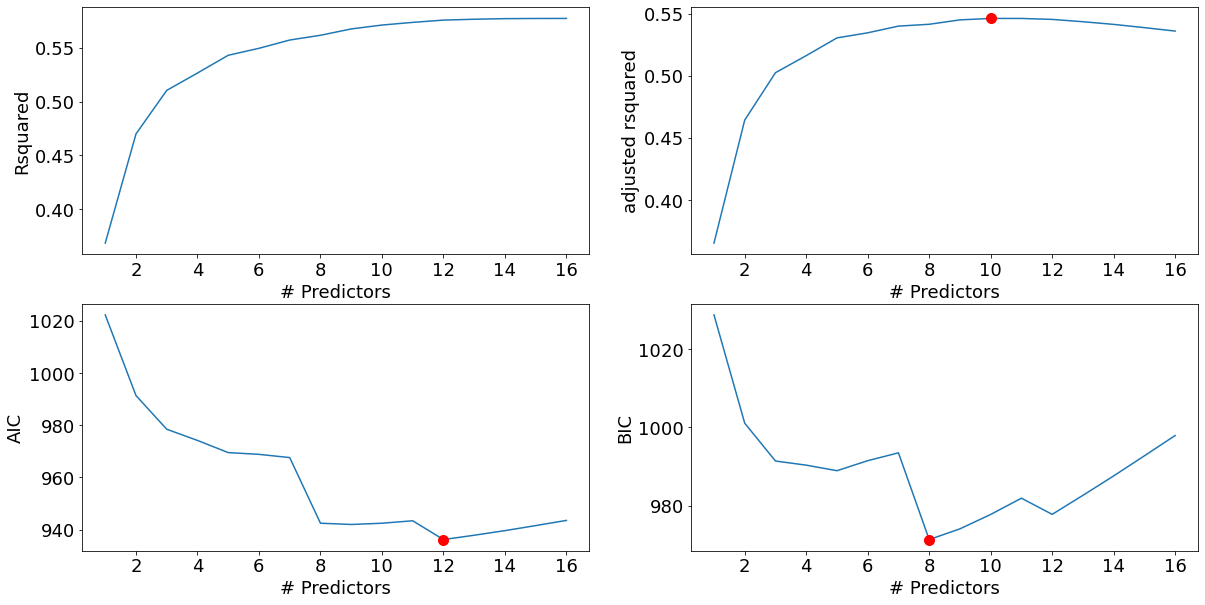

In [76]:
best_sub_plots()

In [77]:
best_bwd_reg_model = models_best['model'][8]
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.562
Model:                             OLS   Adj. R-squared:                  0.541
Method:                  Least Squares   F-statistic:                     27.85
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           1.51e-27
Time:                         14:06:47   Log-Likelihood:                -462.24
No. Observations:                  183   AIC:                             942.5
Df Residuals:                      174   BIC:                             971.4
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -17.2472      5.105     -3.378      0.001     -27.323      -7.171
Christian                  0.0211      0.008      2.596      0.010       0.005       0.037
Muslim                    -0.0163      0.009     -1.730      0.085      -0.035       0.002
drug_deaths_per_100000     0.3993      0.213      1.879      0.062      -0.020       0.819
Median_age                 0.2298      0.046      4.963      0.000       0.138       0.321
pct_female                 0.2400      0.103      2.323      0.021       0.036       0.444
depression_rate            0.6362      0.305      2.086      0.038       0.034       1.238
inv_hom_rate              -0.0005      0.001     -0.551      0.582      -0.002       0.001
log_sui                    0.9575      0.409      2.343      0.020       0.151       1.764
==============================================================================
Omnibus:                       14.706   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               40.653
Skew:                           0.173   Prob(JB):                     1.49e-09
Kurtosis:                       5.283   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

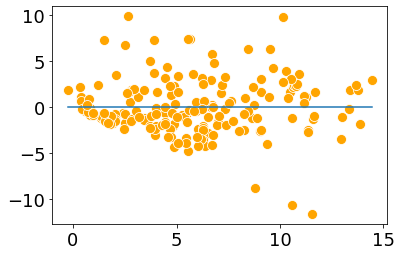

In [78]:
sns.scatterplot(x = best_bwd_reg_model.fittedvalues, y = best_bwd_reg_model.resid, color = 'orange')
sns.lineplot(x = [best_bwd_reg_model.fittedvalues.min(), best_bwd_reg_model.fittedvalues.max()], y = [0,0])


In [79]:
#Using the ols function to create an ols object. 'ols' stands for 'Ordinary least squares'
train05['log_alc_cons'] = np.log(train05['Alcohol_Consumption']+1)
ols_object = sm.ols(formula = 'log_alc_cons~Christian+Muslim+drug_deaths_per_100000+Median_age+pct_female+depression_rate+inv_hom_rate+log_sui', data = train05)
model = ols_object.fit()
model.summary()


/var/folders/5n/yrnrzmms4jgbmdshn221wy3m0000gn/T/ipykernel_23774/3912745477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train05['log_alc_cons'] = np.log(train05['Alcohol_Consumption']+1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_alc_cons   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     24.35
Date:                Sat, 04 Mar 2023   Prob (F-statistic):           7.35e-25
Time:                        13:45:11   Log-Likelihood:                -149.45
No. Observations:                 183   AIC:                             316.9
Df Residuals:                     174   BIC:                             345.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.1215      0.924     -1.214      0.227      -2.945       0.702
Christian                  0.0032      0.001      2.193      0.030       0.000       0.006
Muslim                    -0.0073      0.002     -4.267      0.000      -0.011      -0.004
drug_deaths_per_100000     0.0417      0.038      1.084      0.280      -0.034       0.118
Median_age                 0.0275      0.008      3.282      0.001       0.011       0.044
pct_female                 0.0303      0.019      1.620      0.107      -0.007       0.067
depression_rate            0.0852      0.055      1.544      0.124      -0.024       0.194
inv_hom_rate           -5.004e-05      0.000     -0.302      0.763      -0.000       0.000
log_sui                    0.1165      0.074      1.575      0.117      -0.029       0.262
==============================================================================
Omnibus:                       43.294   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.737
Skew:                          -0.876   Prob(JB):                     1.12e-33
Kurtosis:                       7.102   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

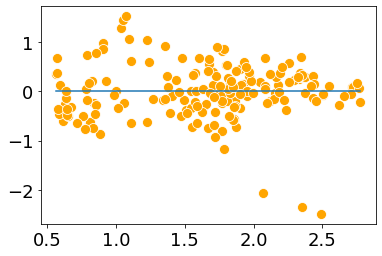

In [80]:
sns.scatterplot(x = model.fittedvalues, y = model.resid, color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0])


### Above, I have tried multiple ways to fit the model with the subset derived from Backward & Forward Stepwise selection, including trying to fit the subset of predictors against the log of Alcohol Consumption, which doesn't help much and reduces R^2 value, indicating it is best not to transform the response. We are now going to try raising the model's goodness-of-fit by trying different interactions:

In [82]:
ols_object = sm.ols(formula = 'Alcohol_Consumption~Christian+Muslim+Christian*Muslim+Median_age*GDP*Education+pct_female+inv_hom_rate+log_sui', data = train05)
model2 = ols_object.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Alcohol_Consumption   R-squared:                       0.594
Model:                             OLS   Adj. R-squared:                  0.562
Method:                  Least Squares   F-statistic:                     19.00
Date:                 Sat, 04 Mar 2023   Prob (F-statistic):           8.84e-27
Time:                         14:08:21   Log-Likelihood:                -455.25
No. Observations:                  183   AIC:                             938.5
Df Residuals:                      169   BIC:                             983.4
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -11.3394      7.932     -1.430      0.155     -26.998       4.320
Christian                    0.0103      0.008      1.215      0.226      -0.006       0.027
Muslim                      -0.0239      0.010     -2.468      0.015      -0.043      -0.005
Christian:Muslim             0.0011      0.000      2.556      0.011       0.000       0.002
Median_age                  -0.2815      0.171     -1.649      0.101      -0.618       0.055
GDP                          0.0002      0.001      0.379      0.705      -0.001       0.001
Median_age:GDP            8.008e-06   1.55e-05      0.518      0.605   -2.25e-05    3.86e-05
Education                   -0.6517      0.350     -1.863      0.064      -1.342       0.039
Median_age:Education         0.0485      0.016      2.939      0.004       0.016       0.081
GDP:Education            -3.126e-05   4.92e-05     -0.635      0.526      -0.000     6.6e-05
Median_age:GDP:Education -2.485e-07   1.45e-06     -0.171      0.864   -3.11e-06    2.62e-06
pct_female                   0.3410      0.141      2.415      0.017       0.062       0.620
inv_hom_rate                -0.0020      0.001     -1.920      0.057      -0.004    5.53e-05
log_sui                      0.7345      0.420      1.750      0.082      -0.094       1.563
==============================================================================
Omnibus:                       15.206   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.312
Skew:                          -0.137   Prob(JB):                     1.45e-10
Kurtosis:                       5.422   Cond. No.                     2.89e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Nathan: Ridge Regression